**Wav2Vec 2.0** is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

![Wav2vec Architecture](https://smilegate.ai/wp-content/uploads/2020/08/w2v2-3-800x533.jpg)

The contextualized representation of the model can be used for a variety of tasks. On HuggingFace, the section [Wav2vec](https://huggingface.co/docs/transformers/model_doc/wav2vec2) describes how the basic Wav2vec model works and what parameters are set to by default.

An introduction on how to use Wav2vec can be found at [Fine-tune Wav2vec](https://huggingface.co/blog/fine-tune-wav2vec2-english).

In this notebook, a downstream model is created to use Wav2vec for Speech Emotion Recognition

The model is trained and tested on various locations and SNR values between SNR+05dB and SNR-20dB on the [QUT-NOISE](https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/) dataset using RAVDESS for the speech segments.

For training recording session A is used, for testing the recording session B. 

# Global Paths

In [1]:
path_files = "drive/MyDrive/Master Thesis/"
path_python_files = path_files + 'Python_files'

# Imports

In [2]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git

!pip install mlflow --quiet

In [ ]:
import copy
from dataclasses import dataclass
from datetime import datetime

import librosa
import matplotlib.pyplot as plt
import mlflow
import numpy as np

from packaging import version
import pexpect
import pickle
import random
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys

from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

import transformers
from transformers import (
    AutoConfig,
    Trainer,
    TrainingArguments,
    is_apex_available,
    Wav2vec2Processor
)
from transformers.file_utils import ModelOutput
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

from typing import Any, Dict, List, Optional, Union, Tuple

In [4]:
sys.path.append(path_python_files)
from configs_private import USERNAME, PASSWORD, EXPERIMENT_URL  # credentials for databricks
from Enums import AudioClipFileLength, FeatureType, RecPlace, SNR
from get_files import get_available_files
from Parameters import Parameters
from process_frames_wav2vec import get_processed_frames
from create_features_and_labels import get_feature_and_labels
from plot_files import plot_file_distribution
from evaluation_tensorflow import Evaluation

# Set values of Experiment
Set the different values depending on the type of experiment that should be run. When running a sweep of experiments, the values can be adjusted here.

In [47]:
snr = SNR.MINUS_FIVE  # SNR value of the current experiment
labels_per_frame = False  # otherwise labels per window
# Type of feature, either raw audio, MFCC, or Spectrogram
feature = FeatureType.SPECTROGRAM
# if True, ignores raw audio during feature extraction to reduce memory needed
# only needed if raw_audio is feature of model is Wav2vec
ignore_raw_audio = False
# which VAD predictions to use (can be Wav2vec, Unet, Perfect, or None)
VAD_predictions = 'None'
# Number of epochs to train on
train_epochs = 10
# split between train and validation set
validation_split = 0.3
# Batch size of the training
batch_size = 32
# If the model should stop early if it is not improving
early_stopping = False
# number of epochs it will wait before stopping early
patience = 10
# optimizer used to train the model (default for all models is Adam)
optimizer='Adam'
# loss function (default is BinaryCrossEntropy, but Hingeloss was also tried)
loss='BinaryCrossentropy'

# Metrics on which to judge the model
metrics = ['accuracy']
# if save_best, the best trained epoch is loaded after training
save_best = True

# number of files for training/testing, can be set to reduce memory
# all files are shuffled before, so it will be split over all categories
nr_train_files = 100
nr_test_files = 10

# Connect to track results
Currently using the databricks community edition to track experiments

In [48]:
# Databricks community version does not allow token generation so instead 
# automatically insert the username and password using expect
child = pexpect.spawn('databricks configure --host https://community.cloud.databricks.com', encoding='utf-8')
child.expect('Username:')
child.sendline(USERNAME)
child.expect('Password:')
child.sendline(PASSWORD)
child.expect('Repeat for confirmation:')
child.sendline(PASSWORD)
print('Connected to Databricks')

Connected to Databricks


In [49]:
mlflow.set_tracking_uri("databricks")
# Create one Experiment per SNR value (from n-20dB to n+05dB in steps of 5)
mlflow.set_experiment(EXPERIMENT_URL+snr.value)

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1010535410834463', experiment_id='1010535410834463', lifecycle_stage='active', name='/Users/d.hamandouche@students.uu.nl/n-05', tags={'mlflow.experiment.sourceName': '/Users/d.hamandouche@students.uu.nl/n-05',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'd.hamandouche@students.uu.nl',
 'mlflow.ownerId': '6054914286087382'}>

In [50]:
mlflow.tensorflow.autolog()

2022/02/23 12:38:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


# Get Data

In [51]:
wav_files_train = get_available_files(path_files+"RAVDESS/", snr, AudioClipFileLength.ONE_MINUTE, rec_place=RecPlace.a)
wav_files_test = get_available_files(path_files+"RAVDESS/", snr, AudioClipFileLength.ONE_MINUTE, rec_place=RecPlace.b) 

Total length: 400
Total length: 400


In [52]:
# Shuffle the list of audio files to avoid having just one category
random.shuffle(wav_files_train)
random.shuffle(wav_files_test)

In [53]:
# set all parameters as wanted
parameter = Parameters()
# set_params_specs is the default for Spectrogram
if feature == FeatureType.SPECTROGRAM or feature == FeatureType.RAW_AUDIO:
    print('Using spectrogram or raw audio parameter')
    parameter.set_params_specs()
else:
    print('Using MFCC parameter')
    parameter.set_params_unet()
parameter

Using spectrogram or raw audio parameter


Parameters(window_size=400, sliding_window_size=40960, hop_length=320, n_mfcc=32, n_mels=32, n_fft=400, fmin=0, fmax=8000, sr=16000, htk=False, center=True, wiener_filters=12, use_wiener_filter=False, feature_type=<FeatureType.SPECTROGRAM: 'Spectrogram'>)

# Train Dataset

100%|██████████| 100/100 [09:40<00:00,  5.81s/it]


Counter({'n-05': 100})
Counter({0: 4396, 2: 45, 4: 39, 3: 33, 1: 30, 7: 27, 5: 15, 6: 15})
Counter({'sA': 100})
Counter({'CAFE-FOODCOURTB-2': 8, 'CAR-WINUPB-2': 8, 'STREET-KG-1': 8, 'CAFE-CAFE-2': 7, 'REVERB-POOL-1': 7, 'STREET-CITY-1': 7, 'HOME-LIVINGB-1': 6, 'HOME-LIVINGB-2': 6, 'CAR-WINUPB-1': 5, 'STREET-CITY-2': 5, 'REVERB-CARPARK-2': 5, 'STREET-KG-2': 5, 'HOME-KITCHEN-2': 4, 'CAFE-CAFE-1': 4, 'CAR-WINDOWNB-2': 4, 'CAR-WINDOWNB-1': 3, 'CAFE-FOODCOURTB-1': 3, 'REVERB-POOL-2': 3, 'REVERB-CARPARK-1': 2})


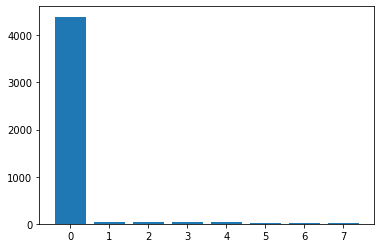

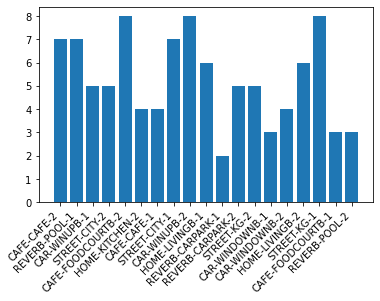

In [54]:
end_train = nr_train_files  # len(wav_files_train)
x_train, y_train, frames_pos_train, frames_train = get_feature_and_labels(
    wav_files_train[0:end_train], parameter, ignore_raw_audio=ignore_raw_audio, 
    emotion=True)
plot_file_distribution(wav_files_train[0:end_train], y_train)

In [55]:
# create train dataset
train_dataset = get_processed_frames(frames_train, x_train, y_train, emotion=True)
# del frames_train, x_train, y_train, frames_pos_train

The target sampling rate: 16000


100%|██████████| 4600/4600 [00:00<00:00, 63293.22it/s]


## Remove Frames with mainly noise

In [56]:
# Remove all files without any noies
if VAD_predictions == 'Perfect':
    train_dataset_speech = [element for element in train_dataset if element['majority_label'] != 0]

In [57]:
# Remove all according to Wav2vec-VAD prediction
if VAD_predictions == 'Wav2vec':
    with open(f'{path_files}predictions_wav2vec_train.p', 'rb') as file_wav:
        predictions = pickle.load(file_wav)
    train_dataset_wav2vec = copy.deepcopy(train_dataset)
    subset_wav2vec_train = [element for index, element in enumerate(train_dataset_wav2vec) if predictions[index] > 0.5]

In [58]:
if VAD_predictions == 'Unet':
    with open(f'{path_files}predictions_unet_train.p', 'rb') as file_wav:
        predictions = pickle.load(file_wav)
    train_dataset_unet = copy.deepcopy(train_dataset)
    subset_wav2vec_train = [element for index, element in enumerate(train_dataset_unet) if predictions[index] > 0.5]

In [59]:
if VAD_predictions == 'None':
    train_dataset_speech = train_dataset

In [60]:
if VAD_predictions == 'Wav2vec' or VAD_predictions == 'Unet':
    for index, element in enumerate(subset_wav2vec_train):
        # as no 0 is in the remaining data, all values need to be reduced by one to start at 0 for the labels
        if element['labels'] == 0:
            # print(index)
            subset_wav2vec_train[index]['labels'] = 1
            subset_wav2vec_train[index]['majority_label'] = 1
            # print(subset_wav2vec[index]['labels'])
            # print(element['labels'])
        subset_wav2vec_train[index]['majority_label'] = element['majority_label'] - 1
        element['labels'] = element['labels'] - 1
    # subset = [element for element in test_dataset if element['majority_label'] != 0]
    # subset = test_dataset

    train_dataset_speech = subset_wav2vec_train

In [61]:
# Split into train and validation
labels = [element['majority_label'] for element in train_dataset_speech]
train_dataset, eval_dataset = train_test_split(train_dataset_speech, test_size=validation_split, random_state=101, stratify=labels)

In [62]:
# we need to distinguish the unique labels in our SER dataset
if not labels_per_frame:
  labels = [frame['labels'] for frame in train_dataset]
else:
  labels = [element for frame in train_dataset for element in frame['labels']]
labels = np.array(labels)
label_list = np.unique(labels)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")
unique, counts = np.unique(labels, return_counts=True)

# find the accuracy of just predicting the majority label
prob_majority = float(counts.max())/len(labels)

print(f'Calculating only the majority class {np.argmax(counts)} equals {prob_majority*100}%')
print(unique, counts)

A classification problem with 8 classes: [0 1 2 3 4 5 6 7]
Calculating only the majority class 0 equals 95.55900621118012%
[0 1 2 3 4 5 6 7] [3077   21   32   23   27   11   10   19]


In [63]:
# we need to distinguish the unique labels in our SER dataset
if not labels_per_frame:
  labels = [frame['labels'] for frame in eval_dataset]
else:
  labels = [element for frame in eval_dataset for element in frame['labels']] #for element in song ]
labels = np.array(labels)
label_list = np.unique(labels)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")
unique, counts = np.unique(labels, return_counts=True)

# find the accuracy of just predicting the majority label
prob_majority = float(counts.max())/len(labels)

print(f'Calculating only the majority class {np.argmax(counts)} equals {prob_majority*100}%')
print(unique, counts)

A classification problem with 8 classes: [0 1 2 3 4 5 6 7]
Calculating only the majority class 0 equals 95.57971014492753%
[0 1 2 3 4 5 6 7] [1319    9   13   10   12    4    5    8]


## Configuration

In [68]:
# use the config from the base model (including all parameter)

model_name_or_path = "facebook/wav2vec2-base-960h"
config = AutoConfig.from_pretrained(
    model_name_or_path,  # Use facebook/wav2vec2-base-960h as base config
    num_labels=num_labels,  # the number of labels discovered above
    problem_type='single_label_classification',
    final_dropout=0.2
)

# set pooling to mean
pooling_mode = "mean"
setattr(config, 'pooling_mode', pooling_mode)

In [69]:
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Model

In [70]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [80]:

class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()

        # Dense Layers
        # config.hidden_size is 768 by default
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dense1 = nn.Linear(config.hidden_size, 500)
        self.dense2 = nn.Linear(76800, 500)
        self.dense3 = nn.Linear(1000, 500)
        self.dense4 = nn.Linear(500, 500)
        self.dense5 = nn.Linear(500, 1024)
        self.output = nn.Linear(500, config.num_labels)
        

        # BatchNormalization (1d and 2d)
        self.batchnorm1d1 = nn.BatchNorm1d(config.hidden_size)
        self.batchnorm1d2 = nn.BatchNorm1d(500)
        self.batchnorm2d1 = nn.BatchNorm2d(20)
        self.batchnorm2d2 = nn.BatchNorm2d(50)
        self.norm = nn.LayerNorm(500)
        # Dropout
        self.dropout = nn.Dropout(config.final_dropout)

        # Convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5), stride=1, padding="same")
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5), stride=1, padding="same")

        # Pooling
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Activation
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        self.blstm_layer = nn.LSTM(input_size=256, hidden_size=config.hidden_size, batch_first=False, bidirectional=True)

        self.flatten = nn.Flatten()

    def forward(self, features, rgb_specs, **kwargs):

        # features is the representation of the raw audio
        x = features
        
        x = self.dense(x)
        x = self.batchnorm1d1(x)
        x = self.dropout(x)
        
        x = self.dense1(x)
        x = self.batchnorm1d2(x)
        
        # spectrogram
        x1 = rgb_specs
        x1 = x1.reshape(x1.shape[0], 1, x1.shape[1], x1.shape[2])
        
        x1 = self.conv1(x1)
        x1 = self.pool(x1)
        x1 = self.batchnorm2d1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.pool(x1)
        x1 = self.batchnorm2d2(x1)

        x1 = x1.reshape(x1.shape[0], x1.shape[1], x1.shape[2]*x1.shape[3])
        x1, (_, _) = self.blstm_layer(x1)
        
        x1 = self.flatten(x1)
        
        x1 = self.dense2(x1)
        x1 = self.dropout(x1)
        x1 = self.relu(x1)
        
        out = torch.cat([x,x1], dim=1)
        
        out = self.dense3(out)
        out = self.dropout(out)
        out = self.norm(out)

        out = self.dense4(out)
        out = self.dropout(out)
        out = self.norm(out)

        out = self.dense4(out)
        out = self.dropout(out)
        out = self.norm(out)

        out = self.dense4(out)
        out = self.dropout(out)
        out = self.norm(out)

        out = self.dense4(out)
        out = self.dropout(out)
        out = self.norm(out)
        
        if labels_per_frame:
            out = self.dense5(out)
            out = out.reshape(-1, 128, 8)
        else:
            out = self.output(out)
            out = self.softmax(out)
        return out


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values, rgb_specs,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states, rgb_specs)

        loss = None
        if labels is not None:
            self.config.problem_type == "single_label_classification"
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, Wav2vec-VAD has a much larger input length than output length. *E.g.*, a normal window has 40960 samples but only 128 labels. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. 

- Evaluation metric. During training, the model should be evaluated on the accuracy per frame. A `compute_metrics` function is defined accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to detect speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of XLSR-Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [81]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
from tensorflow.keras.utils import to_categorical
import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"], 'rgb_specs': feature['rgb_spectrogram']} for feature in features]
        if labels_per_frame:
            label_features = [frame for window in features for frame in window["labels"]]
            label_features = np.array(label_features).reshape(-1, 128)
        else:
            label_features = [window["labels"] for window in features]
            label_features = np.array(label_features)
        d_type = torch.long
        
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        batch["labels"] = torch.tensor(label_features, dtype=d_type)
        return batch

In [82]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [83]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    print(p.predictions.shape)
    
    if labels_per_frame:
        preds = p.predictions.reshape(p.predictions.shape[0]*p.predictions.shape[1], config.num_labels)
        preds = np.argmax(preds, axis=1)
        correct_labels = p.label_ids.reshape(p.label_ids.shape[0]*p.label_ids.shape[1])
    else:
        preds = p.predictions
        preds = np.argmax(preds, axis=1)
        correct_labels = p.label_ids
    return {"accuracy": (preds == correct_labels).astype(np.float32).mean().item()}

In [84]:
# Create Model
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.norm.weight', 'classifier.batchnorm1d2.running_mean', 'wav2vec2.masked_spec_embed', 'classifier.output.weight', 'classifier.norm.bias', 'classifier.blstm_layer.bias_ih_l

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretraining and does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [85]:
model.freeze_feature_extractor()

In a final step, we define all parameters related to training. 

For more explanations on the possible parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

**Note**: If one wants to save the trained models in his/her google drive the commented-out `output_dir` can be used instead.

In [86]:
time = datetime.now()
model_path = f"{path_files}Models/wav2vec2_emotion_unet_labels_{snr.value}/{time}"
training_args = TrainingArguments(
    output_dir=model_path,
    per_device_train_batch_size=batch_size,  #256
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=save_best,
    num_train_epochs=train_epochs,
    fp16=True,
    save_steps=1000,
    eval_steps=100,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

In [87]:
if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()


In [88]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

Using amp half precision backend


## Training

Training will take between several hours depending on the GPU allocated to this notebook. 

In case you want to use this google colab to fine-tune your model, you should make sure that your training doesn't stop due to inactivity. A simple hack to prevent this is to paste the following code into the console of this tab (right mouse click -> inspect -> Console tab and insert code).

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [89]:
mlflow.end_run()

In [90]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3220
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 640
  Gradient Accumulation steps = 20
  Total optimization steps = 50


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.326924,0.955797
1,1.523800,1.319037,0.955797


***** Running Evaluation *****
  Num examples = 1380
  Batch size = 32


(1380, 8)


Saving model checkpoint to drive/MyDrive/Master Thesis/Models/wav2vec2_emotion_unet_labels_n-05/2022-02-23 12:52:21.058222/checkpoint-5
Configuration saved in drive/MyDrive/Master Thesis/Models/wav2vec2_emotion_unet_labels_n-05/2022-02-23 12:52:21.058222/checkpoint-5/config.json
Model weights saved in drive/MyDrive/Master Thesis/Models/wav2vec2_emotion_unet_labels_n-05/2022-02-23 12:52:21.058222/checkpoint-5/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1380
  Batch size = 32


(1380, 8)


Saving model checkpoint to drive/MyDrive/Master Thesis/Models/wav2vec2_emotion_unet_labels_n-05/2022-02-23 12:52:21.058222/checkpoint-10
Configuration saved in drive/MyDrive/Master Thesis/Models/wav2vec2_emotion_unet_labels_n-05/2022-02-23 12:52:21.058222/checkpoint-10/config.json
Model weights saved in drive/MyDrive/Master Thesis/Models/wav2vec2_emotion_unet_labels_n-05/2022-02-23 12:52:21.058222/checkpoint-10/pytorch_model.bin


KeyboardInterrupt: ignored

# Evaluation

In [93]:
VAD_predictions = 'Wav2vec'

In [133]:
vad_files_test = []
if VAD_predictions == 'Wav2vec':
    with open(f'{path_files}wav_files_test_wav2vec.txt') as file_wav:
        for line in file_wav:
            vad_files_test.append(line.strip())
    with open(f'{path_files}predictions_wav2vec.p', 'rb') as file_wav:
      predictions_wav2vec = pickle.load(file_wav)
if VAD_predictions == 'Unet':
    with open(f'{path_files}wav_files_test_unet.txt') as file_wav:
        for line in file_wav:
            vad_files_test.append(line.strip())
    with open(f'{path_files}predictions_unet.p', 'rb') as file_wav:
      predictions_wav2vec = pickle.load(file_wav)

In [ ]:
end_test = 100 #nr_test_files #len(wav_files_test)
features_test, y_test, frames_pos_test, frames_test = get_feature_and_labels(vad_files_test[0:end_test], parameter, emotion=True)
plot_file_distribution(wav_files_test[0:end_test], y_test)

In [128]:
test_dataset = get_processed_frames(frames_test, features_test, y_test, emotion=True)

loading feature extractor configuration file https://huggingface.co/facebook/wav2vec2-base-960h/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/07e398f6c4f4eb4f676c75befc5ace223491c79cea1109fb4029751892d380a1.bc3155ca0bae3a39fc37fc6d64829c6a765f46480894658bb21c08db6155358d
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}



The target sampling rate: 16000


100%|██████████| 4600/4600 [00:00<00:00, 66735.84it/s]


In [129]:
# we need to distinguish the unique labels in our SER dataset
if not labels_per_frame:
  labels = [frame['labels'] for frame in test_dataset]
else:
  labels = [element for frame in test_dataset for element in frame['labels']]
labels = np.array(labels)
label_list = np.unique(labels)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")
unique, counts = np.unique(labels, return_counts=True)
prob_majority = float(counts.max())/len(labels)
# if prob_majority < 0.5:
    # prob_majority = 1-prob_majority
print(f'Calculating only the majority class {np.argmax(counts)} equals {prob_majority*100}%')
print(unique, counts)

A classification problem with 8 classes: [0 1 2 3 4 5 6 7]
Calculating only the majority class 0 equals 95.95652173913042%
[0 1 2 3 4 5 6 7] [4414   27   27   36   36   21   15   24]


In [135]:
predictions_wav2vec = predictions_wav2vec.mean(axis=1)

In [136]:
test_dataset_wav2vec = copy.deepcopy(test_dataset)
subset_wav2vec = [element for index, element in enumerate(test_dataset_wav2vec) if predictions_wav2vec[index] > 0.5]
if not labels_per_frame:
    for index, element in enumerate(subset_wav2vec):
        # as no 0 is in the remaining data, all values need to be reduced by one to start at 0 for the labels
        if element['labels'] == 0:
            # print(index)
            subset_wav2vec[index]['labels'] = 1
            subset_wav2vec[index]['majority_label'] = 1
        subset_wav2vec[index]['majority_label'] = element['majority_label']

labels_wav2vec = [s['labels'] for s in subset_wav2vec]

In [137]:
predictions = trainer.predict(subset_wav2vec)
labels_test = labels_wav2vec

***** Running Prediction *****
  Num examples = 2119
  Batch size = 32


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,1.326924,0.955797
1,1.523800,1.319037,0.955797


(2119, 8)


In [138]:
if labels_per_frame:
    predictions = np.argmax(predictions.predictions, axis=2)
    predictions = predictions.reshape(-1)
else:
    predictions = np.argmax(predictions.predictions, axis=1)

In [139]:
labels_test = np.array(labels_test).reshape(-1)

In [ ]:
print(classification_report(labels_test, predictions, target_names=['calm/neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']))

In [ ]:

cf_matrix = confusion_matrix(labels_test, predictions)
print(cf_matrix/cf_matrix.sum())
plt.figure(figsize= (16,9))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix/cf_matrix.sum(), annot=True, 
            xticklabels=[ 'no speech', 'calm/neutral', 'happy', 'sad', 'angry', 
                         'fearful', 'disgust', 'surprised'], 
            yticklabels=['no speech', 'calm/neutral', 'happy', 'sad', 'angry', 
                         'fearful', 'disgust', 'surprised'], fmt='.2%')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(model_path + '/confusion_matrix_no_speech_added.png')
plt.show()
